##Проект 1799: "Разработка системы предсказания параметров цифровых схем с использованием методов машинного обучения"

##Подготовка и исследование данных

###Импорт всех библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import os
import math
import optuna



sns.set(font_scale=1.4, style='whitegrid')

##Инициализация устройства

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

##Загрузка данных

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('drive/MyDrive/embeddings.csv') #Файл содержит уже очищенные от выбросов данные
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41192 entries, 0 to 41191
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      41192 non-null  int64  
 1   File            41192 non-null  object 
 2   Area            41192 non-null  float64
 3   Delay           41192 non-null  float64
 4   embedding       41192 non-null  object 
 5   New_embeddings  41192 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 1.9+ MB


In [6]:
data.drop(['New_embeddings', 'Unnamed: 0'], axis=1, inplace=True)
data

,File,Area,Delay,embedding
0,CCGRCG1,11.26,139.61,"[[-0.0021449089981615543, 0.000945725420024246..."
1,CCGRCG2,21.27,147.38,"[[-0.0021449089981615543, 0.000945725420024246..."
2,CCGRCG3,11.25,194.25,"[[-0.002141991164535284, 0.0009532237891107798..."
3,CCGRCG4,11.25,107.18,"[[-0.0021485977340489626, 0.000949225854128599..."
4,CCGRCG5,22.50,160.62,"[[-0.0021652388386428356, 0.000933241331949830..."
...,...,...,...,...
41187,CCGRCG11005,60.06,265.41,"[[-0.0021583845373243093, 0.000951010966673493..."
41188,CCGRCG11006,102.57,358.25,"[[-0.00213915528729558, 0.0009182162466458976,..."
41189,CCGRCG11007,140.06,459.67,"[[-0.0021358621306717396, 0.000899522274266928..."
41190,CCGRCG11008,401.49,780.42,"[[-0.002138545038178563, 0.0009022692102007568..."


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41192 entries, 0 to 41191
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   File       41192 non-null  object 
 1   Area       41192 non-null  float64
 2   Delay      41192 non-null  float64
 3   embedding  41192 non-null  object 
dtypes: float64(2), object(2)
memory usage: 1.3+ MB


Посмотрим на наши эмбеддинги

In [9]:
data['embedding'][255]

'[[-0.002152559347450733, 0.0009587233071215451, 0.020421821624040604, 0.03604637086391449, -0.03722260519862175, -0.02848442643880844, 0.025840260088443756, 0.03590499237179756, -0.02006523311138153, -0.01506724115461111, 0.02954143099486828, -0.006135474890470505, -0.018150070682168007, 0.02622663415968418, -0.01944422908127308, -0.007272362243384123, 0.01151384599506855, 0.003970533609390259, -0.03316284343600273, -0.037806760519742966, 0.029262060299515724, 0.020292656496167183, 0.02704456076025963, 0.0030577874276787043, 0.025405921041965485], [-0.013612494803965092, -0.0037808783818036318, 0.023076921701431274, -0.03008740209043026, -0.01574854366481304, -0.030041908845305443, -0.003714316990226507, 0.03815561160445213, -0.02927679568529129, -0.009338419884443283, -0.0077545857056975365, 0.03230588510632515, -0.023739874362945557, 0.0001809560926631093, -0.01901940628886223, -0.03841422498226166, 0.02003874070942402, -0.03503160551190376, -0.017578089609742165, -0.000128517043776

Эмбеддинги представлены в виде строк, что не подходит для обучения моделей. Исправим это и создадим массивы чисел

In [10]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [11]:
new_embedding = []
for str in data['embedding']:
    result = []
    if '\n' in str:
        res = str.split('\n')
    else:
        res = str.split('], ')
    for mass in res:
        s = mass.replace(', dtype=float32',' ').replace('(', ' ').replace(')',' ').replace(',',' ').replace('[','').replace(']','').split(' ')
        tmp = []
        for word in s:
            if is_number(word):
                tmp.append(float(word))
        result.append(tmp)
    r = [np.array(sublist) for sublist in result]
    new_embedding.append(r)

Сравним длины полученных массивов

In [12]:
len(new_embedding[1]), len(new_embedding[2435])

(8, 38)

Так как np.array и torch.FloatTensor не могут иметь массивы разных размеров, дополним их все нулевыми эмбеддингами до максимальной длины самой большой последовательности

In [11]:
max_subarrays = max(len(arr) for arr in new_embedding)
print(max_subarrays)
print(min(len(arr) for arr in new_embedding))

for i in range(len(new_embedding)):
    while len(new_embedding[i]) < max_subarrays:
        new_embedding[i] = np.vstack([new_embedding[i], np.zeros(25)])

141
4


In [12]:
X = np.array(new_embedding)
y_area = np.array(data['Area'])
y_delay = np.array(data['Delay'])

In [ ]:
X.shape

(41192, 141, 25)

Создадим отдельно данные для обучения/тестирования моделей предсказания площади и моделей предсказания задержки

In [13]:
# Для площади
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X, y_area, test_size=0.2, random_state=42)
# Для задержки
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X, y_delay, test_size=0.2, random_state=42)

Переведём всё в тензоры, так как модели реализованы на при помощи PyTorch. Также уменьшим размер эмбеддингов до 24, чтобы можно было протестировать разное количество "голов" в механизме внимания ([1, 2, 3, 4, 6, 8, 12] вместо [1, 5])

In [14]:
X_train_a = torch.FloatTensor(np.array([torch.FloatTensor(X) for X in X_train_a]))[:, :, :-1]
X_test_a = torch.FloatTensor(np.array([torch.FloatTensor(X) for X in X_test_a]))[:, :, :-1]
y_train_a = torch.FloatTensor(y_train_a)
y_test_a = torch.FloatTensor(y_test_a)

In [15]:
X_train_d = torch.FloatTensor(np.array([torch.FloatTensor(X) for X in X_train_d]))[:, :, :-1]
X_test_d = torch.FloatTensor(np.array([torch.FloatTensor(X) for X in X_test_d]))[:, :, :-1]
y_train_d = torch.FloatTensor(y_train_d)
y_test_d = torch.FloatTensor(y_test_d)

In [ ]:
X_train_a.shape, y_train_a.shape

(torch.Size([32953, 141, 24]), torch.Size([32953]))

In [ ]:
# train = dict(zip(y_train, X_train))
# test = dict(zip(y_test, X_test))

##Реализация функций и классов для создания и обучения моделей

In [16]:
# Функция для разбиения данных на батчи
def get_dataloaders(trainset, testset, batch_size=4):

  trainloader_X = torch.utils.data.DataLoader(trainset[0], batch_size=batch_size,
                                            shuffle=False, num_workers=2)
  trainloader_y = torch.utils.data.DataLoader(trainset[1], batch_size=batch_size,
                                              shuffle=False, num_workers=2)

  testloader_X = torch.utils.data.DataLoader(testset[0], batch_size=batch_size,
                                           shuffle=False, num_workers=2)
  testloader_y = torch.utils.data.DataLoader(testset[1], batch_size=batch_size,
                                           shuffle=False, num_workers=2)

  return [trainloader_X, trainloader_y], [testloader_X, testloader_y]
  # return trainloader, testloader

In [17]:
# Функция для отображения графика обучения
def plot_training(train_losses, valid_losses, valid_accuracies):
  plt.figure(figsize=(12, 9))
  plt.subplot(2, 1, 1)
  plt.xlabel('epoch')
  plt.plot(train_losses[1:], label='train_loss')
  plt.plot(valid_losses[1:], label='valid_loss')
  plt.legend()

  plt.subplot(2, 1, 2)
  plt.xlabel('epoch')
  plt.plot(valid_accuracies, label='Mean Realative Error')
  plt.legend()

Реализуем необходимый нам модуль слоя внимания

In [18]:
class MultiHeadAttentionLayer(nn.Module):
  def __init__(self, hid_dim, n_heads, dropout, device):
    super().__init__()

    assert hid_dim % n_heads == 0

    self.hid_dim = hid_dim
    self.n_heads = n_heads
    self.head_dim = hid_dim // n_heads

    self.fc_q = nn.Linear(hid_dim, hid_dim)
    self.fc_k = nn.Linear(hid_dim, hid_dim)
    self.fc_v = nn.Linear(hid_dim, hid_dim)

    self.fc_o = nn.Linear(hid_dim, hid_dim)

    self.dropout = nn.Dropout(dropout)

    self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

  def forward(self, query, key, value, mask=None):
    batch_size = query.shape[0]

    Q = self.fc_q(query)
    K = self.fc_k(key)
    V = self.fc_v(value)

    Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

    energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

    if mask is not None:
      mask = mask[:, None, None, :]
      energy = energy.masked_fill(mask==0, -1e10)

    attention = torch.softmax(energy, dim=-1)
    x = torch.matmul(self.dropout(attention), V)
    x = x.permute(0, 2, 1, 3).contiguous()
    x = x.view(batch_size, -1, self.hid_dim)
    x = self.fc_o(x)

    return x, attention # возвращаем ещё attention, чтобы можно было при желании наблюдать за его изменением

Реализуем модуль позиционного кодирования для учёта порядка эмбеддингов

In [19]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, 1, d_model)
        position = torch.arange(max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        # x должен быть вида [seq_len, batch_size, embedding_dim]
        x = x + self.pe[:x.size(0)]
        x = x.permute(1, 0, 2)

        return x

Реализуем структуру нейронной сети с механизмом самовнимания

In [20]:
class GraphTransformer(nn.Module):
  def __init__(self, in_dim, max_seq_length, hid_dim=2048, dropout=0, device=device, n_heads=1):
    super(GraphTransformer, self).__init__()

    self.in_dim = in_dim
    self.device = device
    self.pos_encoder = PositionalEncoding(in_dim, max_seq_length) # Слой для учёта порядка эмбеддингов
    self.attn = MultiHeadAttentionLayer(hid_dim=self.in_dim,
                                        n_heads=n_heads,
                                        dropout=dropout,
                                        device=self.device) # Слой внимания

    self.ln1 = nn.LayerNorm(in_dim) # Нормализация всего слоя
    self.ln2 = nn.LayerNorm(in_dim)

    fc_blocks = []

    fc_blocks.append(nn.Linear(self.in_dim, hid_dim).to(self.device))
    fc_blocks.append(nn.Linear(hid_dim, self.in_dim).to(self.device))
    fc_blocks.append(nn.Linear(self.in_dim, 1).to(self.device))

    self.fc_blocks = fc_blocks # Полносвязный слой
    self.dropout = nn.Dropout(dropout) # Слой dropout, чтобы не застревать в локальном минимуме


  def forward(self, x, mask=None):
    x = self.pos_encoder(x.permute(1, 0, 2))
    attn_out1 = self.attn(x, x, x, mask=mask)[0]
    x = self.ln1(x + self.dropout(attn_out1))

    x = x[:, 0, :].squeeze().to(self.device) #size ([16], [25]) now
    ff_out = self.fc_blocks[-2](F.relu(self.fc_blocks[-3](x)))
    x = self.ln2(x + self.dropout(ff_out))
    x = self.fc_blocks[-1](x)
    # print(x.shape)


    return x

Функция обучения модели и записи значений функции потерь на тренировочной и валидационной выборка, а также записи относительной ошибки

In [21]:
def fit(epochs, model, loss_func, opt, train_dl, val_dl):
  train_losses = []
  val_losses = []
  valid_re = []

  for epoch in range(epochs):

    # Переведём модель в состояние обучения
    model.train()
    loss_sum = 0
    for xb, yb in zip(*train_dl):
      #print(1)
      # Переведём всё на одно устройство
      xb, yb = xb.to(device), yb.to(device)

      loss = loss_func(model(xb).squeeze(), yb)
      loss_sum += loss.item()

      loss.backward()
      opt.step()
      opt.zero_grad()
    train_losses.append(loss_sum / len(train_dl[0]))

    # Будем иногда выводить значения функции потерь для мониторинга адекватности обучения
    if (epoch + 1) % 10 == 0:
      print(f'Epoch: {epoch + 1}')
      print(f'Loss: {train_losses[epoch]:.4f}')

    # Переведём модель в состояние предсказания
    model.eval()
    loss_sum = 0
    correct = 0
    num = 0
    with torch.no_grad():
      for xb, yb in zip(*val_dl):
        xb, yb = xb.to(device), yb.to(device)

        probs = model(xb).squeeze()
        loss_sum += loss_func(probs, yb).item()
        correct += (torch.abs(probs - yb)/yb).sum().item()
        num += len(xb)

    val_losses.append(loss_sum / len(val_dl[0]))
    valid_re.append(correct/num)

  return train_losses, val_losses, valid_re

Функция для предсказания

In [22]:
def predict(model, testset):
  model.eval()
  with torch.no_grad():
    preds = []
    for xb in testset[0]:
      pred = model(xb.to(device))
      preds.append(pred.squeeze())

  # Переведём preds в масств numpy для использования в метриках
  preds = np.array(torch.cat(preds[:-1]).cpu())
  y_test = []
  for y in testset[1]:
    y_test.append(y)

  # Переведём y_test в массив numpy для использования в метриках
  y_test = np.array(torch.cat(y_test[:-1]).numpy())

  return y_test, preds

In [23]:
IN_DIM = 24
HID_DIM = 100
EPOCHS = 60
BATCH_SIZE = 32
LR = 2e-3
MAX_SEQ_LENGTH = 141

##Обучение модели для предсказания задержки

Определение функции, которую будем оптимизировать

In [ ]:
def objective(trial):

  # Гиперпараметры для оптимизации
  learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
  hid_dim = trial.suggest_int('hidden_dimension', 24, 1024)
  dropout = trial.suggest_float('dropout', 1e-1, 1, log=True)
  n_heads = trial.suggest_categorical('n_heads', [3, 4, 6, 8])

  # Модель с оптимизируемыми гиперпараметрами
  model =  GraphTransformer(in_dim=IN_DIM,
                          max_seq_length=MAX_SEQ_LENGTH,
                          hid_dim=hid_dim,
                          n_heads=n_heads,
                          dropout=dropout).to(device)

  # Посмотрим количество параметров самой модели
  print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

  # Получим тензоры для обучения/тестирования, разделённые на батчи
  trainset, testset = get_dataloaders([X_train_d, y_train_d], [X_test_d, y_test_d], BATCH_SIZE)

  # Определение функции потерь и оптимизатора градиента
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

  # Обучим модель
  fit(EPOCHS, model, criterion, optimizer, trainset, testset)

  # Протестируем модель
  y_test, y_pred = predict(model, testset)

  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  re = np.mean((np.abs(y_pred - y_test))/y_test)

  print(f'MSE: {mse:.4f}, R²: {r2:.4f}, RE: {re:.4f}')

  return mse

Оптимизация гиперпараметров

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
print(f'Лучшие параметры: {best_params}')

[I 2024-05-13 02:45:50,970] A new study created in memory with name: no-name-4da4df62-5d72-491f-8902-0e4b4263a9da


Number of parameters:  2496
Epoch: 1
Loss: 183060.8780
Epoch: 11
Loss: 181486.3127
Epoch: 21
Loss: 180871.4745
Epoch: 31
Loss: 180253.7002
Epoch: 41
Loss: 179634.4351
Epoch: 51
Loss: 179019.4866


[I 2024-05-13 02:55:24,701] Trial 0 finished with value: 181509.046875 and parameters: {'learning_rate': 1.7543230568656284e-05, 'hidden_dimension': 946, 'dropout': 0.13474541721631295, 'n_heads': 4}. Best is trial 0 with value: 181509.046875.


MSE: 181509.0469, R²: -4.1982, RE: 0.9771
Number of parameters:  2496


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1
Loss: 180691.8568
Epoch: 11
Loss: 152738.9119
Epoch: 21
Loss: 128343.2669
Epoch: 31
Loss: 106835.6647
Epoch: 41
Loss: 88207.8929
Epoch: 51
Loss: 72456.2161


[I 2024-05-13 03:05:09,283] Trial 1 finished with value: 60907.890625 and parameters: {'learning_rate': 0.0007057904044416308, 'hidden_dimension': 314, 'dropout': 0.5412156298812456, 'n_heads': 8}. Best is trial 1 with value: 60907.890625.


MSE: 60907.8906, R²: -0.7443, RE: 0.3802
Number of parameters:  2496


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1
Loss: 182754.1249
Epoch: 11
Loss: 179573.7211
Epoch: 21
Loss: 176954.6763
Epoch: 31
Loss: 174569.8494
Epoch: 41
Loss: 172213.1692
Epoch: 51
Loss: 169874.8485


[I 2024-05-13 03:14:52,797] Trial 2 finished with value: 170519.1875 and parameters: {'learning_rate': 6.1030587034069585e-05, 'hidden_dimension': 944, 'dropout': 0.40624403656127644, 'n_heads': 6}. Best is trial 1 with value: 60907.890625.


MSE: 170519.1875, R²: -3.8834, RE: 0.9299
Number of parameters:  2496


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1
Loss: 182406.3175
Epoch: 11
Loss: 174705.6221
Epoch: 21
Loss: 168220.5243
Epoch: 31
Loss: 161892.7278
Epoch: 41
Loss: 155720.3745
Epoch: 51
Loss: 149703.1903


[I 2024-05-13 03:24:23,992] Trial 3 finished with value: 146328.59375 and parameters: {'learning_rate': 0.00016790447158466484, 'hidden_dimension': 334, 'dropout': 0.6098776740931318, 'n_heads': 6}. Best is trial 1 with value: 60907.890625.


MSE: 146328.5938, R²: -3.1906, RE: 0.8187
Number of parameters:  2496


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1
Loss: 182436.4588
Epoch: 11
Loss: 179062.2455
Epoch: 21
Loss: 176434.3862
Epoch: 31
Loss: 173912.0430
Epoch: 41
Loss: 171427.6921
Epoch: 51
Loss: 168967.7403


[I 2024-05-13 03:34:04,724] Trial 4 finished with value: 169563.203125 and parameters: {'learning_rate': 5.336395495081229e-05, 'hidden_dimension': 606, 'dropout': 0.11500408961344344, 'n_heads': 3}. Best is trial 1 with value: 60907.890625.


MSE: 169563.2031, R²: -3.8560, RE: 0.9257
Number of parameters:  2496


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1
Loss: 182479.0729
Epoch: 11
Loss: 178866.1942
Epoch: 21
Loss: 176035.7388
Epoch: 31
Loss: 173306.0781
Epoch: 41
Loss: 170606.1530
Epoch: 51
Loss: 167933.5852


[I 2024-05-13 03:43:46,574] Trial 5 finished with value: 168321.546875 and parameters: {'learning_rate': 7.136469464484309e-05, 'hidden_dimension': 45, 'dropout': 0.12484526900791264, 'n_heads': 8}. Best is trial 1 with value: 60907.890625.


MSE: 168321.5469, R²: -3.8205, RE: 0.9202
Number of parameters:  2496


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1
Loss: 156122.5043
Epoch: 11
Loss: 15530.3295
Epoch: 21
Loss: 10963.4647
Epoch: 31
Loss: 10346.4201
Epoch: 41
Loss: 9943.3484
Epoch: 51
Loss: 9762.0803


[I 2024-05-13 03:54:06,848] Trial 6 finished with value: 8492.3125 and parameters: {'learning_rate': 0.014181261900505544, 'hidden_dimension': 869, 'dropout': 0.18750932824022093, 'n_heads': 8}. Best is trial 6 with value: 8492.3125.


MSE: 8492.3125, R²: 0.7568, RE: 0.2222
Number of parameters:  2496


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1
Loss: 179058.4145
Epoch: 11
Loss: 129686.5092
Epoch: 21
Loss: 91111.9097
Epoch: 31
Loss: 62913.0785
Epoch: 41
Loss: 44914.9026
Epoch: 51
Loss: 36583.9321


[I 2024-05-13 04:04:22,422] Trial 7 finished with value: 35032.13671875 and parameters: {'learning_rate': 0.0013816888859124658, 'hidden_dimension': 701, 'dropout': 0.1618289958133376, 'n_heads': 8}. Best is trial 6 with value: 8492.3125.


MSE: 35032.1367, R²: -0.0033, RE: 0.4772
Number of parameters:  2496


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1
Loss: 182110.6486
Epoch: 11
Loss: 170566.8037
Epoch: 21
Loss: 160481.9018
Epoch: 31
Loss: 150794.7841
Epoch: 41
Loss: 141495.6402
Epoch: 51
Loss: 132591.5121


[I 2024-05-13 04:14:05,591] Trial 8 finished with value: 125507.5546875 and parameters: {'learning_rate': 0.00024006593984885377, 'hidden_dimension': 452, 'dropout': 0.7334391946811484, 'n_heads': 3}. Best is trial 6 with value: 8492.3125.


MSE: 125507.5547, R²: -2.5944, RE: 0.7136
Number of parameters:  2496


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1
Loss: 170943.2216
Epoch: 11
Loss: 46603.2511
Epoch: 21
Loss: 21152.5357
Epoch: 31
Loss: 11091.0959
Epoch: 41
Loss: 10773.8048
Epoch: 51
Loss: 10699.1375


[I 2024-05-13 04:23:57,636] Trial 9 finished with value: 10608.6650390625 and parameters: {'learning_rate': 0.0050365712454609095, 'hidden_dimension': 842, 'dropout': 0.26437698369240525, 'n_heads': 3}. Best is trial 6 with value: 8492.3125.


MSE: 10608.6650, R²: 0.6962, RE: 0.2248
Лучшие параметры: {'learning_rate': 0.014181261900505544, 'hidden_dimension': 869, 'dropout': 0.18750932824022093, 'n_heads': 8}


Переведём в тензор весь датасет для обучения на нём модели с оптимизированными гиперпараметрами

In [24]:
X = torch.FloatTensor(np.array([torch.FloatTensor(x) for x in X]))[:, :, :-1]
y_delay = torch.FloatTensor(y_delay)
y_area = torch.FloatTensor(y_area)

Присваивание лучших гиперпараметров

In [25]:
HID_DIM = 869
N_HEADS = 8
DROPOUT = 0.1875
LR = 0.01418

Модель с лучшими параметрами

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 10
Loss: 15268.0826
Epoch: 20
Loss: 8944.7043
Epoch: 30
Loss: 8493.0586
Epoch: 40
Loss: 8392.1924
Epoch: 50
Loss: 8462.4374
MSE: 8249.7451, R²: 0.7637, RE: 0.2052


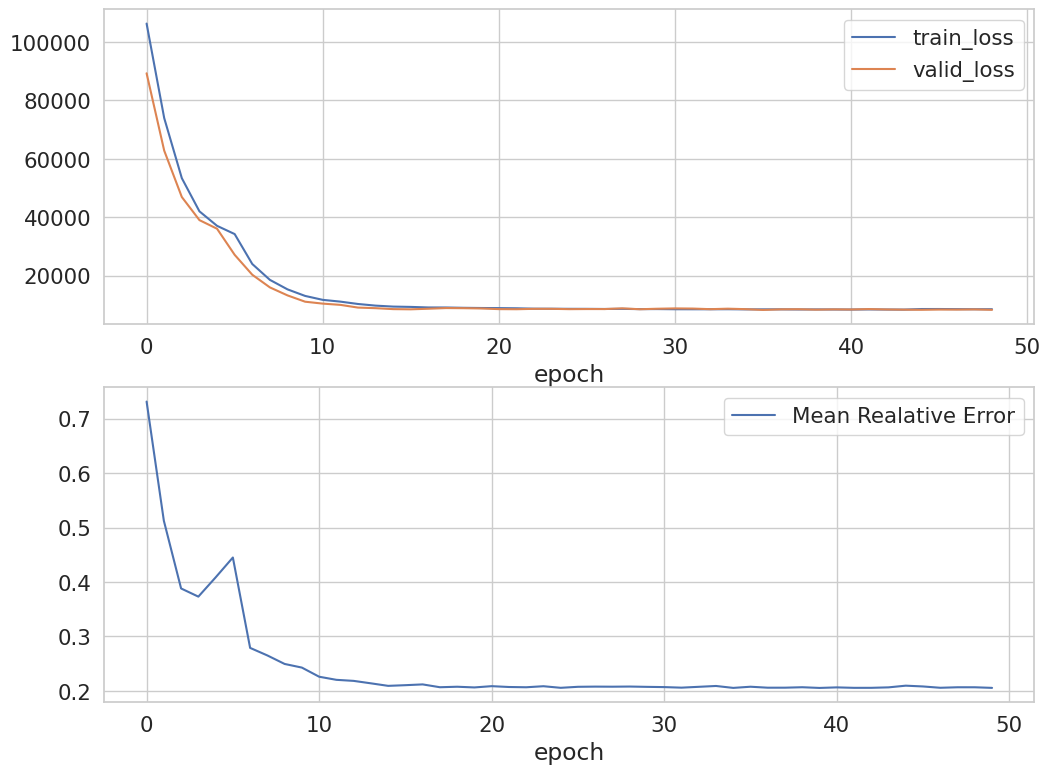

In [26]:
# Создание модели
model = GraphTransformer(in_dim=IN_DIM,
                          max_seq_length=MAX_SEQ_LENGTH,
                          hid_dim=HID_DIM,
                          n_heads=N_HEADS,
                          dropout=DROPOUT).to(device)

# Получение тензоров, разделённых на батчи
trainset, testset = get_dataloaders([X, y_delay], [X_test_d, y_test_d], BATCH_SIZE)

# Определение функции потерь и оптимизатора градиента
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.999))

# Запуск обучения и просмотр графика обучения
info = fit(epochs=50, model=model, loss_func=criterion, opt=optimizer, train_dl=trainset, val_dl=testset)
plot_training(*info)


y_test, y_pred = predict(model, testset)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
re = np.mean((np.abs(y_pred - y_test))/y_test)

print(f'MSE: {mse:.4f}, R²: {r2:.4f}, RE: {re:.4f}')

##Модель для предсказания площади

Определение функции, которую будем оптимизировать

In [28]:
def objective(trial):

  # Гиперпараметры для оптимизации
  learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
  hid_dim = trial.suggest_int('hidden_dimension', 24, 1024)
  dropout = trial.suggest_float('dropout', 1e-1, 1, log=True)
  n_heads = trial.suggest_categorical('n_heads', [3, 4, 6, 8])

  # Модель с оптимизируемыми гиперпараметрами
  model =  GraphTransformer(in_dim=IN_DIM,
                          max_seq_length=MAX_SEQ_LENGTH,
                          hid_dim=hid_dim,
                          n_heads=n_heads,
                          dropout=dropout).to(device)

  # Посмотрим на общее количество параметров модели
  print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

  # Получение тензоров, разделённых на батчи
  trainset, testset = get_dataloaders([X_train_a, y_train_a], [X_test_a, y_test_a], BATCH_SIZE)

  # Определение функции потерьи оптимизатора градиента
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

  # Обучение модели
  fit(EPOCHS, model, criterion, optimizer, trainset, testset)

  # Тестирование модели
  y_test, y_pred = predict(model, testset)

  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  re = np.mean((np.abs(y_pred - y_test))/y_test)

  print(f'MSE: {mse:.4f}, R²: {r2:.4f}, RE: {re:.4f}')

  return mse

Оптимизация функции

In [29]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=8)

best_params = study.best_params
print(f'Лучшие параметры: {best_params}')

[I 2024-05-14 01:55:31,345] A new study created in memory with name: no-name-d1b52f08-379d-499e-8aae-7ad54d0b5f7b


Number of parameters:  2496


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 10
Loss: 26786.9376
Epoch: 20
Loss: 26063.8335
Epoch: 30
Loss: 25462.1473
Epoch: 40
Loss: 24902.5244
Epoch: 50
Loss: 24358.4055
Epoch: 60
Loss: 23830.1228


[I 2024-05-14 02:04:39,584] Trial 0 finished with value: 23932.388671875 and parameters: {'learning_rate': 4.740906239345698e-05, 'hidden_dimension': 770, 'dropout': 0.674627439858956, 'n_heads': 8}. Best is trial 0 with value: 23932.388671875.


MSE: 23932.3887, R²: -0.7185, RE: 0.7096
Number of parameters:  2496


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 10
Loss: 14087.6598
Epoch: 20
Loss: 14088.6194
Epoch: 30
Loss: 14084.5785
Epoch: 40
Loss: 14084.0408
Epoch: 50
Loss: 14081.0547
Epoch: 60
Loss: 14078.7240


[I 2024-05-14 02:13:39,086] Trial 1 finished with value: 13923.98828125 and parameters: {'learning_rate': 0.013341624185184878, 'hidden_dimension': 541, 'dropout': 0.9187238366937481, 'n_heads': 4}. Best is trial 1 with value: 13923.98828125.


MSE: 13923.9883, R²: 0.0002, RE: 1.9944
Number of parameters:  2496


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 10
Loss: 26010.0607
Epoch: 20
Loss: 24831.4252
Epoch: 30
Loss: 23731.0490
Epoch: 40
Loss: 22692.8389
Epoch: 50
Loss: 21716.5704
Epoch: 60
Loss: 20802.2995


[I 2024-05-14 02:22:40,987] Trial 2 finished with value: 20929.25390625 and parameters: {'learning_rate': 9.703765410532549e-05, 'hidden_dimension': 499, 'dropout': 0.12217924241722602, 'n_heads': 3}. Best is trial 1 with value: 13923.98828125.


MSE: 20929.2539, R²: -0.5029, RE: 0.7225
Number of parameters:  2496


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 10
Loss: 25487.9908
Epoch: 20
Loss: 23682.2470
Epoch: 30
Loss: 22038.3326
Epoch: 40
Loss: 20556.7497
Epoch: 50
Loss: 19237.0930
Epoch: 60
Loss: 18078.8824


[I 2024-05-14 02:31:50,937] Trial 3 finished with value: 18124.80859375 and parameters: {'learning_rate': 0.00019993696251246085, 'hidden_dimension': 907, 'dropout': 0.1025664948786654, 'n_heads': 6}. Best is trial 1 with value: 13923.98828125.


MSE: 18124.8086, R²: -0.3015, RE: 0.8991
Number of parameters:  2496


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 10
Loss: 7187.2320
Epoch: 20
Loss: 7038.6076
Epoch: 30
Loss: 6993.1994
Epoch: 40
Loss: 6920.6647
Epoch: 50
Loss: 7042.2412
Epoch: 60
Loss: 6981.6295


[I 2024-05-14 02:40:57,696] Trial 4 finished with value: 6379.17431640625 and parameters: {'learning_rate': 0.09291855066390488, 'hidden_dimension': 677, 'dropout': 0.2161815113511233, 'n_heads': 6}. Best is trial 4 with value: 6379.17431640625.


MSE: 6379.1743, R²: 0.5419, RE: 1.3291
Number of parameters:  2496


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 10
Loss: 14085.2244
Epoch: 20
Loss: 14083.5194
Epoch: 30
Loss: 14083.8655
Epoch: 40
Loss: 14084.1956
Epoch: 50
Loss: 14039.4713
Epoch: 60
Loss: 13889.4176


[I 2024-05-14 02:50:04,356] Trial 5 finished with value: 11918.5009765625 and parameters: {'learning_rate': 0.07154744774863143, 'hidden_dimension': 167, 'dropout': 0.8168281268666632, 'n_heads': 4}. Best is trial 4 with value: 6379.17431640625.


MSE: 11918.5010, R²: 0.1442, RE: 1.4259
Number of parameters:  2496


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 10
Loss: 22032.4165
Epoch: 20
Loss: 18049.7713
Epoch: 30
Loss: 15543.7317
Epoch: 40
Loss: 14383.4933
Epoch: 50
Loss: 14108.1388
Epoch: 60
Loss: 14079.5167


[I 2024-05-14 02:59:17,900] Trial 6 finished with value: 13932.7421875 and parameters: {'learning_rate': 0.0005814159509969972, 'hidden_dimension': 489, 'dropout': 0.5718746360870688, 'n_heads': 8}. Best is trial 4 with value: 6379.17431640625.


MSE: 13932.7422, R²: -0.0005, RE: 1.9431
Number of parameters:  2496


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 10
Loss: 18159.0649
Epoch: 20
Loss: 14426.9360
Epoch: 30
Loss: 14082.8057
Epoch: 40
Loss: 8167.6319
Epoch: 50
Loss: 5610.6852
Epoch: 60
Loss: 4575.3553


[I 2024-05-14 03:08:45,534] Trial 7 finished with value: 5312.06689453125 and parameters: {'learning_rate': 0.0011057148509650279, 'hidden_dimension': 241, 'dropout': 0.7352938643014617, 'n_heads': 3}. Best is trial 7 with value: 5312.06689453125.


MSE: 5312.0669, R²: 0.6186, RE: 0.5013
Лучшие параметры: {'learning_rate': 0.0011057148509650279, 'hidden_dimension': 241, 'dropout': 0.7352938643014617, 'n_heads': 3}


Так полученные лучшие гиперпараметры являются очень плохими, используем полученные данные из оптимизации для модели предсказания задержки

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 10
Loss: 3273.0335
Epoch: 20
Loss: 1599.2458
Epoch: 30
Loss: 1532.6401
Epoch: 40
Loss: 1782.9988
Epoch: 50
Loss: 1493.2829
MSE: 1118.1313, R²: 0.9197, RE: 0.3550


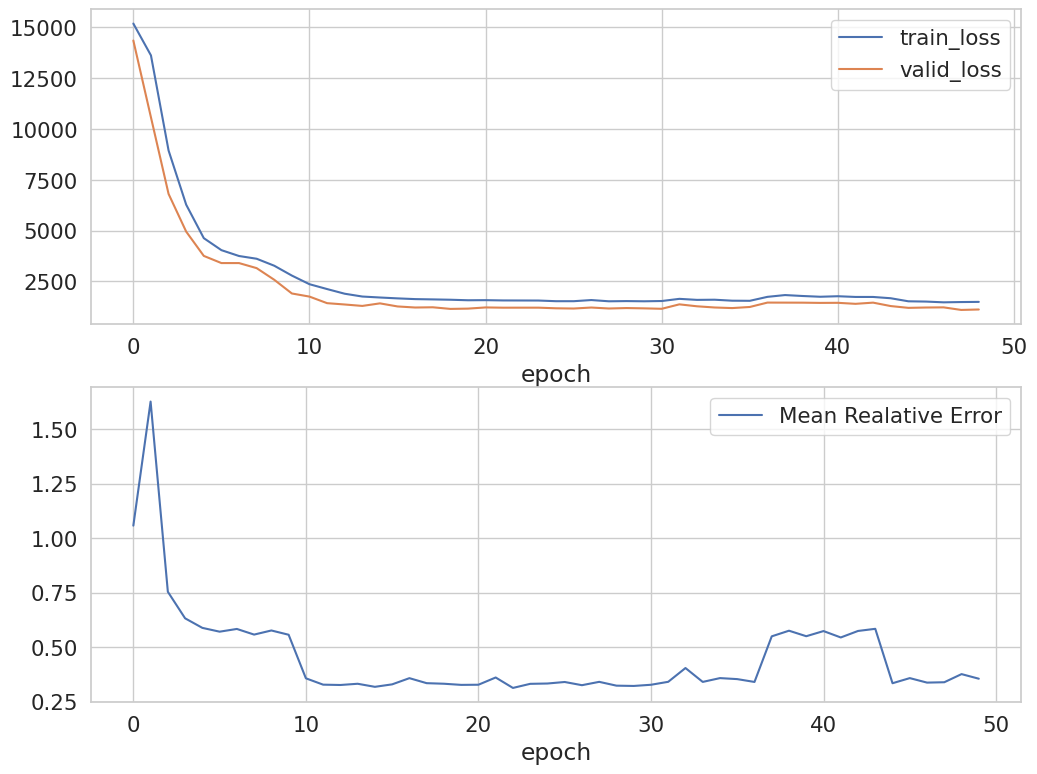

In [27]:
# Создание модели
model = GraphTransformer(in_dim=IN_DIM,
                          max_seq_length=MAX_SEQ_LENGTH,
                          hid_dim=HID_DIM,
                          n_heads=N_HEADS,
                          dropout=DROPOUT).to(device)

# Получение тензоров, разделённых на батчи
trainset, testset = get_dataloaders([X, y_area], [X_test_a, y_test_a], BATCH_SIZE)

# Определение функции потерь и оптимизатора градиента
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.999))

# Обучение модели и просмотр графика обучения
info = fit(epochs=50, model=model, loss_func=criterion, opt=optimizer, train_dl=trainset, val_dl=testset)
plot_training(*info)

# Тестирование модели
y_test, y_pred = predict(model, testset)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
re = np.mean((np.abs(y_pred - y_test))/y_test)

print(f'MSE: {mse:.4f}, R²: {r2:.4f}, RE: {re:.4f}')

Из полученных метрик можно сделать вывод, что следует увеличить размер датасета путём увеличения размера эмбеддингов, последовательностей эмбеддингов и количество схем